In [1]:
import talib
import numpy as np
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
import os


/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

In [5]:
class getYahooFinanceData:
    '''class to help fetch data from Yahoo Finance - both currency and equities'''
    def __init__(self):
        print("object initialized")

    def fetch_data(self, start_date, end_date, currency_list, interval='1h'):
        # Loop through each ticker and download 1-hour data
        dict_ = {}
        for ticker in currency_list:
            data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
            
            # Drop certain columns if they exist
            drop_columns = ['Volume', 'Adj Close']
            for col in drop_columns:
                if col in data.columns:
                    data = data.drop(columns=[col])
        
            dict_[ticker] = data

            print("data pull complete for: ", ticker)
    
        return dict_

In [159]:
from backtesting import Backtest, Strategy
import pandas as pd

def make_bollinger_indicators(df, period=20, atr_factor=2):
    df = df.copy()
    
    # Calculate Bollinger Bands
    df['SMA'] = df['Close'].ewm(span=period, adjust=False).mean() 
    df['STD'] = df['Close'].rolling(window=period).std()   # Standard Deviation
    df['Upper Band'] = df['SMA'] + (df['STD'] * atr_factor)
    df['Lower Band'] = df['SMA'] - (df['STD'] * atr_factor)
    
    # Calculate Bollinger Band Width (BBW)
    df['BBW'] = (df['Upper Band'] - df['Lower Band']) / df['SMA']
    
    # Define a threshold for low BBW (suggested < 5% for low volatility)
    threshold = 0.05
    
    # Strategy: Buy when BBW is below threshold and price breaks above the upper band
    df['Signal'] = 0  # Initialize Signal column
    
    # Generate signals
    df.loc[(df['BBW'] < threshold) & (df['Close'] > df['Upper Band']), 'Signal'] = 1  # Buy signal
    df.loc[(df['BBW'] < threshold) & (df['Close'] < df['Lower Band']), 'Signal'] = -1  # Sell signal

    return df

class BollingerStrategy(Strategy):
    period = 20
    atr_factor = 2

    def init(self):
        self.data = make_bollinger_indicators(self.data, period=self.period, atr_factor=self.atr_factor)
        self.signal = self.I(lambda: self.data['Signal'])
        self.close = self.I(lambda: self.data['Close'])
        self.bbw = self.I(lambda: self.data['BBW'])

    def next(self):
        if self.signal[-1] == 1:
            self.buy()
        elif self.signal[-1] == -1:
            self.position.close()

def execute_bollinger_strategy(data, strategy_class, period=20, atr_factor=2, cash=10**5, commission=0.000, exclusive_orders=True):
    strategy = BollingerStrategy
    strategy.data = data
    
    strategy.period = period
    strategy.atr_factor = atr_factor
    bt = Backtest(data, strategy, cash=cash, commission=commission, exclusive_orders=exclusive_orders)
    stats = bt.run()
    return stats

def optimize_bollinger_strategy(data, BollingerStrategy, periods, atr_factors, metric):
    strategy = BollingerStrategy
    strategy.data = data
    bt = Backtest(data, strategy, cash=10**5, commission=0.000, exclusive_orders=True)
    stats = bt.optimize(period=periods, atr_factor=atr_factors, maximize=metric)
    return stats



start_date = "1994-07-01"
end_date = "2024-12-31"

data_obj = getYahooFinanceData()
snp_data = data_obj.fetch_data(start_date, end_date, ["SPY"], interval='1d')["SPY"]

# Example execution with a DataFrame `snp_data` containing 'Close' prices
metric = "Sharpe Ratio"
periods = np.arange(5, 50, 1).tolist()
atr_factors = np.arange(1, 10, 0.1).tolist()
stats = execute_bollinger_strategy(snp_data, BollingerStrategy, period=40, atr_factor=1.8)
# stats = optimize_bollinger_strategy(snp_data, BollingerStrategy, periods, atr_factors, metric)

days = stats['Duration'].days
years = days / 365.25
cash = 10**5

# CAGR calculation
cagr = (stats["Equity Final [$]"] / cash) ** (1 / years) - 1
cagr_percentage = cagr * 100

print(stats)
print(f"CAGR: {cagr_percentage:.2f}%")


object initialized


[*********************100%***********************]  1 of 1 completed

data pull complete for:  SPY
Start                     1994-07-01 00:00:00
End                       2024-11-29 00:00:00
Duration                  11109 days 00:00:00
Exposure Time [%]                   51.919561
Equity Final [$]                315085.101868
Equity Peak [$]                 357353.099915
Return [%]                         215.085102
Buy & Hold Return [%]             1252.145835
Return (Ann.) [%]                     3.84884
Volatility (Ann.) [%]                12.59752
Sharpe Ratio                         0.305524
Sortino Ratio                        0.453163
Calmar Ratio                         0.101433
Max. Drawdown [%]                   -37.94457
Avg. Drawdown [%]                   -2.268896
Max. Drawdown Duration     3946 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                  249
Win Rate [%]                        68.273092
Best Trade [%]                      44.787018
Worst Trade [%]                    -14.791841
Avg. 

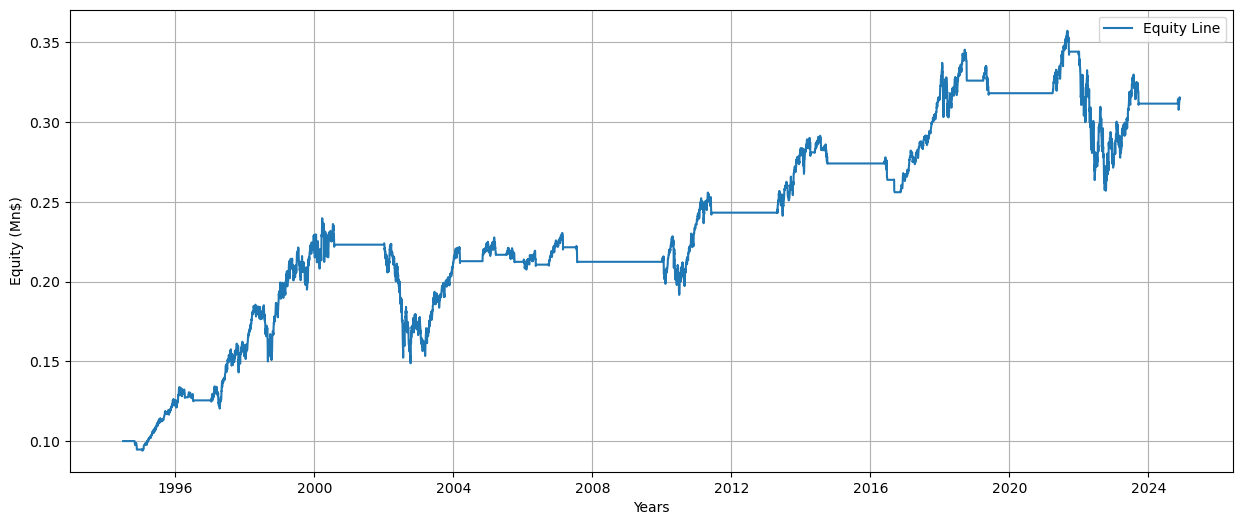

In [161]:
# print(stats)
import matplotlib.pyplot as plt
ticker = "SPY"
plt.figure(figsize=(15, 6))
# convert x-axis to log scale
plt.plot(stats._equity_curve.index, (stats._equity_curve['Equity'])/1e6,
         label='Equity Line')
plt.xlabel('Years')
plt.ylabel('Equity (Mn$)')
plt.legend()
plt.grid()
plt.show()